# **Predictive Maintenance: Proactive Safety in Industrial Operations**

Why it matters:
*   SIF Prevention: Early hazard detection stops major incidents.
*   Environmental Protection: Prevents leaks, emissions, and hazardous releases.


Data Source: https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv




Import Libraries

In [25]:
# Install required libraries
!pip install pandas matplotlib seaborn scikit-learn shap lime imbalanced-learn xgboost

# Core data and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, precision_recall_curve, auc
from sklearn.base import clone

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline

# Check NumPy version
print(np.__version__)


2.0.2


In [26]:
# Load dataset from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)

# Quick overview
print("Shape:", df.shape)
df.head()


Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

In [27]:
# Basic dataset info
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float

In [28]:
# Print Missing Values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [29]:
# Statistical Summary
print("\nStatistical Summary (Numerical Features):")
print(df.describe())


Statistical Summary (Numerical Features):
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               11

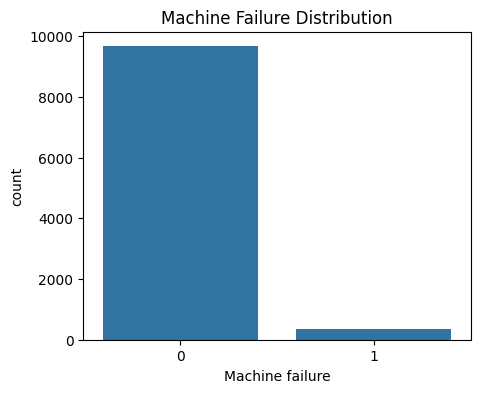

In [30]:
# Check target distribution for Machine failure
plt.figure(figsize=(5,4))
sns.countplot(x='Machine failure', data=df)
plt.title('Machine Failure Distribution')
plt.show()

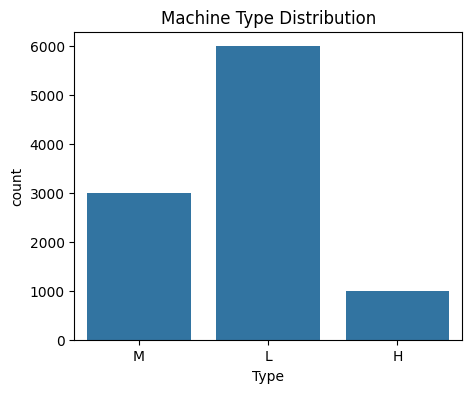

In [31]:
# Distribution of machine types
plt.figure(figsize=(5,4))
sns.countplot(x='Type', data=df)
plt.title('Machine Type Distribution')
plt.show()

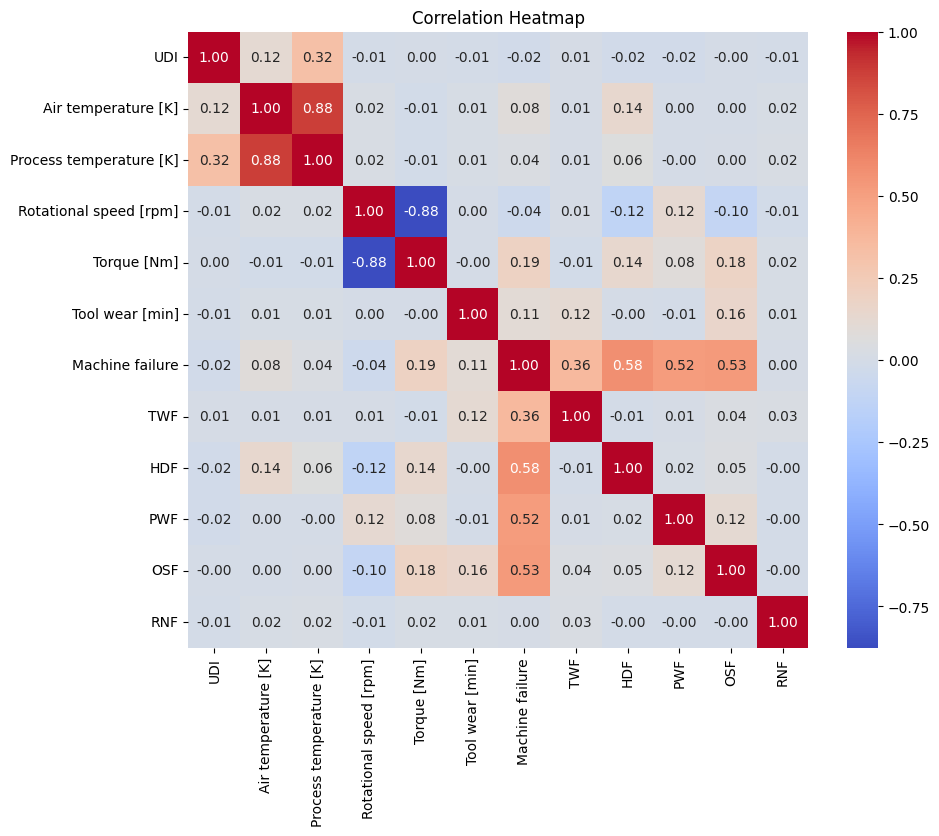

In [32]:
# Correlation heatmap (numerical features)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

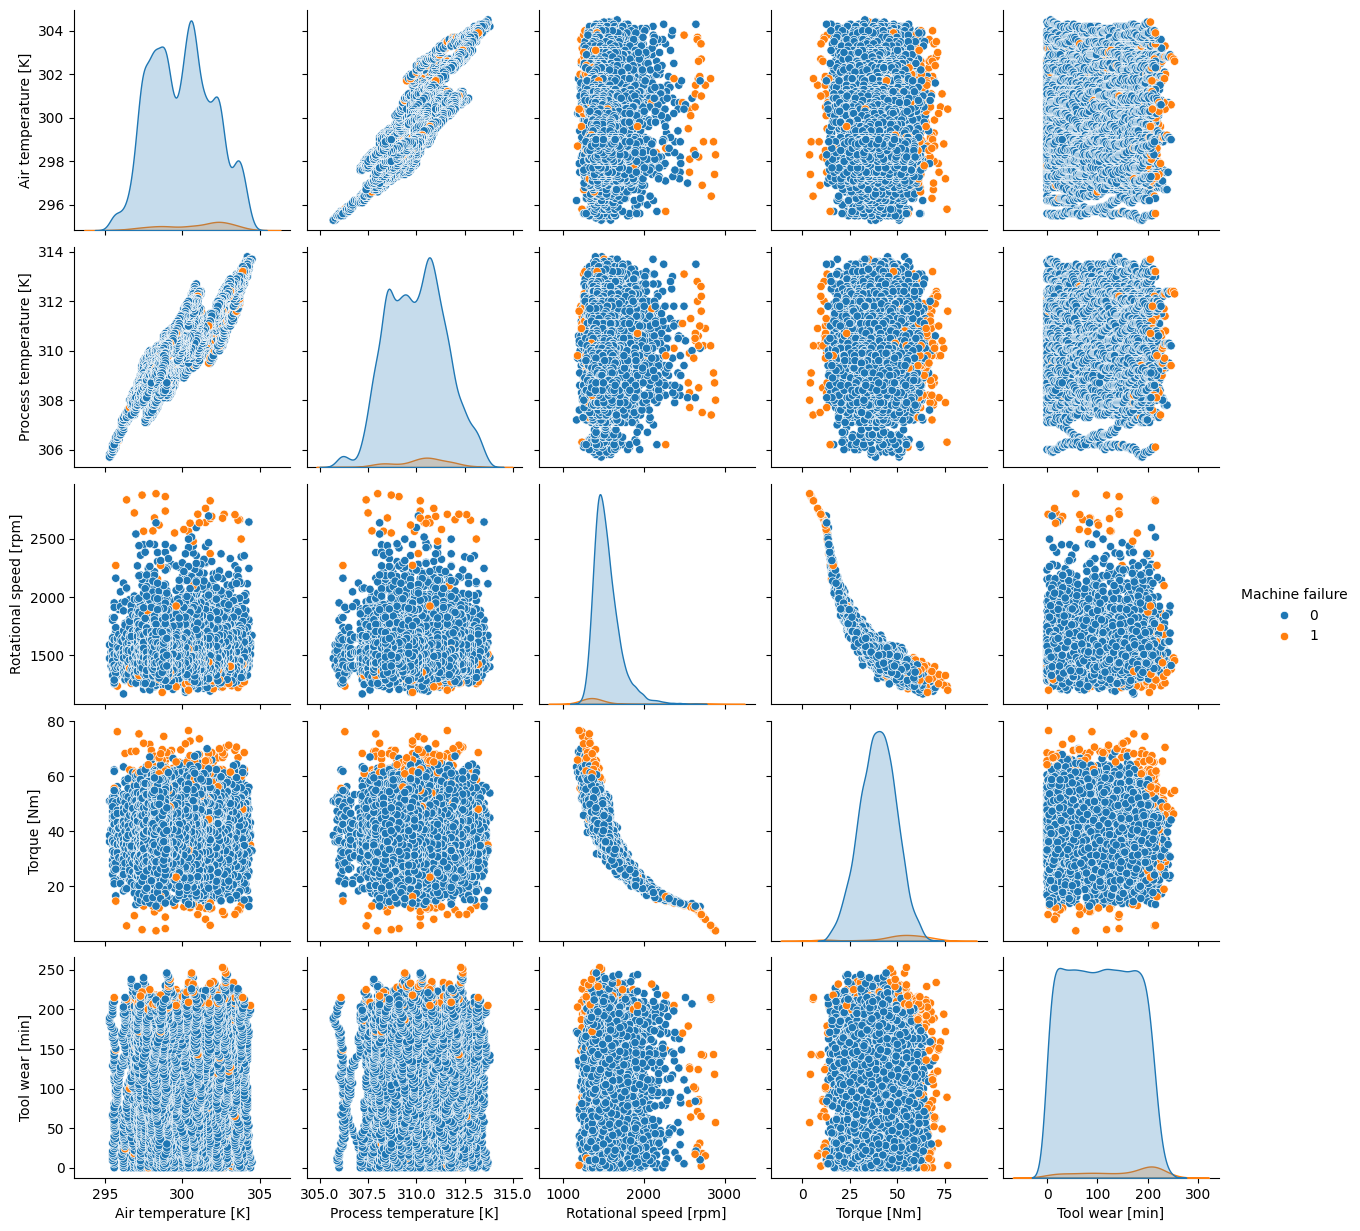

In [33]:
# Pairplot for key features vs. machine failure
sns.pairplot(df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']],
             hue='Machine failure', diag_kind='kde')
plt.show()

# Feature Engineering


In [34]:
# Feature Engineering
df['Temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

In [35]:
# Drop ID columns (not useful for prediction)
df = df.drop(["Product ID", "UDI", "TWF", "HDF", "PWF", "OSF", "RNF"], axis=1)


In [36]:
# Define features and target
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']


In [37]:
# Identify categorical and numerical columns
categorical_cols = ['Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]


In [38]:
# Preprocessing: OneHot for categorical, StandardScaler for numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Prepare Train and Test Data

In [39]:
# Create a Stratified 5-fold Cross Validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model_all_metrics(model, X, y, model_name):
    # Build a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Preprocessor step (scaling, encoding, etc.)
        ('classifier', model)            # Classifier step
    ])

    # Initialize a dictionary to store metrics for each fold
    metrics = {
        'Model': model_name,
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': [],
        'ROC-AUC': [],
        'PR-AUC': []
    }

    # Loop through each fold in StratifiedKFold
    for train_idx, test_idx in cv.split(X, y):
        # Split into train and test sets based on fold indices
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Clone the pipeline so that the original is not overwritten
        model_clone = clone(pipeline)
        model_clone.fit(X_train, y_train)  # Train on training fold

        # Predictions and predicted probabilities
        y_pred = model_clone.predict(X_test)               # Class predictions
        y_prob = model_clone.predict_proba(X_test)[:, 1]   # Probability of class 1

        # Calculate metrics for this fold
        acc = (y_pred == y_test).mean()  # Accuracy

        # Precision: TP / (TP + FP), avoid division by zero
        precision = np.sum((y_pred == 1) & (y_test == 1)) / max(np.sum(y_pred == 1), 1)

        # Recall: TP / (TP + FN), avoid division by zero
        recall = np.sum((y_pred == 1) & (y_test == 1)) / max(np.sum(y_test == 1), 1)

        # F1-score: harmonic mean of precision and recall
        f1 = (2 * precision * recall) / max((precision + recall), 1e-9)

        # ROC-AUC score: Area under ROC curve
        roc = roc_auc_score(y_test, y_prob)

        # PR-AUC: Area under Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_curve, precision_curve)

        # Append fold metrics to lists
        metrics['Accuracy'].append(acc)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1-score'].append(f1)
        metrics['ROC-AUC'].append(roc)
        metrics['PR-AUC'].append(pr_auc)

    # Return the average metrics across folds
    return {
        'Model': model_name,
        'Accuracy': np.mean(metrics['Accuracy']),
        'Precision': np.mean(metrics['Precision']),
        'Recall': np.mean(metrics['Recall']),
        'F1-score': np.mean(metrics['F1-score']),
        'ROC-AUC': np.mean(metrics['ROC-AUC']),
        'PR-AUC': np.mean(metrics['PR-AUC'])
    }


# **Machine Learning Models**

In [40]:
# Initialize a list to store evaluation results for each model
results = []

# Evaluate Logistic Regression model with balanced class weights
results.append(evaluate_model_all_metrics(
    LogisticRegression(class_weight='balanced', random_state=42),  # Model instance
    X, y, "Logistic Regression"                                     # Data and model name
))

# Evaluate Decision Tree model with balanced class weights and max depth of 5
results.append(evaluate_model_all_metrics(
    DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5),  # Model instance
    X, y, "Decision Tree"                                                            # Data and model name
))

# Evaluate Random Forest model with 200 trees, balanced class weights, and parallel processing
results.append(evaluate_model_all_metrics(
    RandomForestClassifier(
        n_estimators=200,                 # Number of trees
        class_weight='balanced',          # Handle class imbalance
        random_state=42,                  # Reproducibility
        n_jobs=-1                         # Use all CPU cores
    ),
    X, y, "Random Forest"                 # Data and model name
))

# Convert the results list into a pandas DataFrame for tabular display
df_results = pd.DataFrame(results)

# Display the final results table
df_results

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
0,Logistic Regression,0.8194,0.136120,0.808253,0.232938,0.900340,0.426264
1,Decision Tree,0.9435,0.362002,0.873222,0.511771,0.904406,0.731281
2,Random Forest,0.9836,0.949822,0.548903,0.690572,0.966190,0.818113


In [41]:
# Calculate positive class weight = (# negative samples / # positive samples)
pos_weight = (y == 0).sum() / (y == 1).sum()

results.append(evaluate_model_all_metrics(
    XGBClassifier(
        scale_pos_weight=pos_weight,
        eval_metric='logloss',     # prevents warnings
        use_label_encoder=False,   # prevents warnings
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    X, y, "XGBoost"
))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:36:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:36:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:36:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:36:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:36:37] WARNING: /w

In [42]:
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
0,Logistic Regression,0.8194,0.136120,0.808253,0.232938,0.900340,0.426264
1,Decision Tree,0.9435,0.362002,0.873222,0.511771,0.904406,0.731281
2,Random Forest,0.9836,0.949822,0.548903,0.690572,0.966190,0.818113
3,XGBoost,0.9843,0.783645,0.749342,0.763835,0.972261,0.829322


In [43]:
# Build a pipeline so categorical 'Type' gets one-hot encoded before XGB sees it
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        use_label_encoder=False,
        scale_pos_weight=pos_weight,
        n_jobs=-1,
        random_state=42
    ))
])

# Random search space (note the 'classifier__' prefixes!)
param_dist = {
    "classifier__n_estimators": np.arange(300, 1001, 50),
    "classifier__learning_rate": np.logspace(-3, -0.5, 12),
    "classifier__max_depth": np.arange(3, 11),
    "classifier__min_child_weight": np.arange(1, 11),
    "classifier__subsample": np.linspace(0.6, 1.0, 9),
    "classifier__colsample_bytree": np.linspace(0.6, 1.0, 9),
    "classifier__reg_alpha": np.logspace(-4, 0, 9),
    "classifier__reg_lambda": np.logspace(-2, 2, 9),
}

# Stratified CV splitter (if not already defined)
from sklearn.model_selection import StratifiedKFold
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search on the PIPELINE (so preprocessing happens inside each fold)
rand = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=80,
    scoring="f1",
    cv=cv5,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)
rand.fit(X, y)

print("Best CV F1:", rand.best_score_)
print("Best Params:", rand.best_params_)

# Clean best params for a bare XGBClassifier (so we can reuse your evaluate() which builds its own pipeline)
best_params_clean = {k.replace("classifier__", ""): v for k, v in rand.best_params_.items()}

xgb_tuned = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    use_label_encoder=False,
    scale_pos_weight=pos_weight,
    n_jobs=-1,
    random_state=42,
    **best_params_clean
)

# Append tuned model metrics (your function wraps it with the same preprocessor internally)
results.append(evaluate_model_all_metrics(xgb_tuned, X, y, "XGBoost (Tuned)"))

# Show updated comparison table
df_results = pd.DataFrame(results)
df_results


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV F1: 0.7832792895957688
Best Params: {'classifier__subsample': np.float64(0.85), 'classifier__reg_lambda': np.float64(0.31622776601683794), 'classifier__reg_alpha': np.float64(0.03162277660168379), 'classifier__n_estimators': np.int64(450), 'classifier__min_child_weight': np.int64(2), 'classifier__max_depth': np.int64(9), 'classifier__learning_rate': np.float64(0.038986037025490715), 'classifier__colsample_bytree': np.float64(0.9)}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:41:58] WARNING: /w

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC
0,Logistic Regression,0.8194,0.136120,0.808253,0.232938,0.900340,0.426264
1,Decision Tree,0.9435,0.362002,0.873222,0.511771,0.904406,0.731281
2,Random Forest,0.9836,0.949822,0.548903,0.690572,0.966190,0.818113
3,XGBoost,0.9843,0.783645,0.749342,0.763835,0.972261,0.829322
4,XGBoost (Tuned),0.9853,0.784352,0.784723,0.783279,0.976223,0.842558


# **Results**

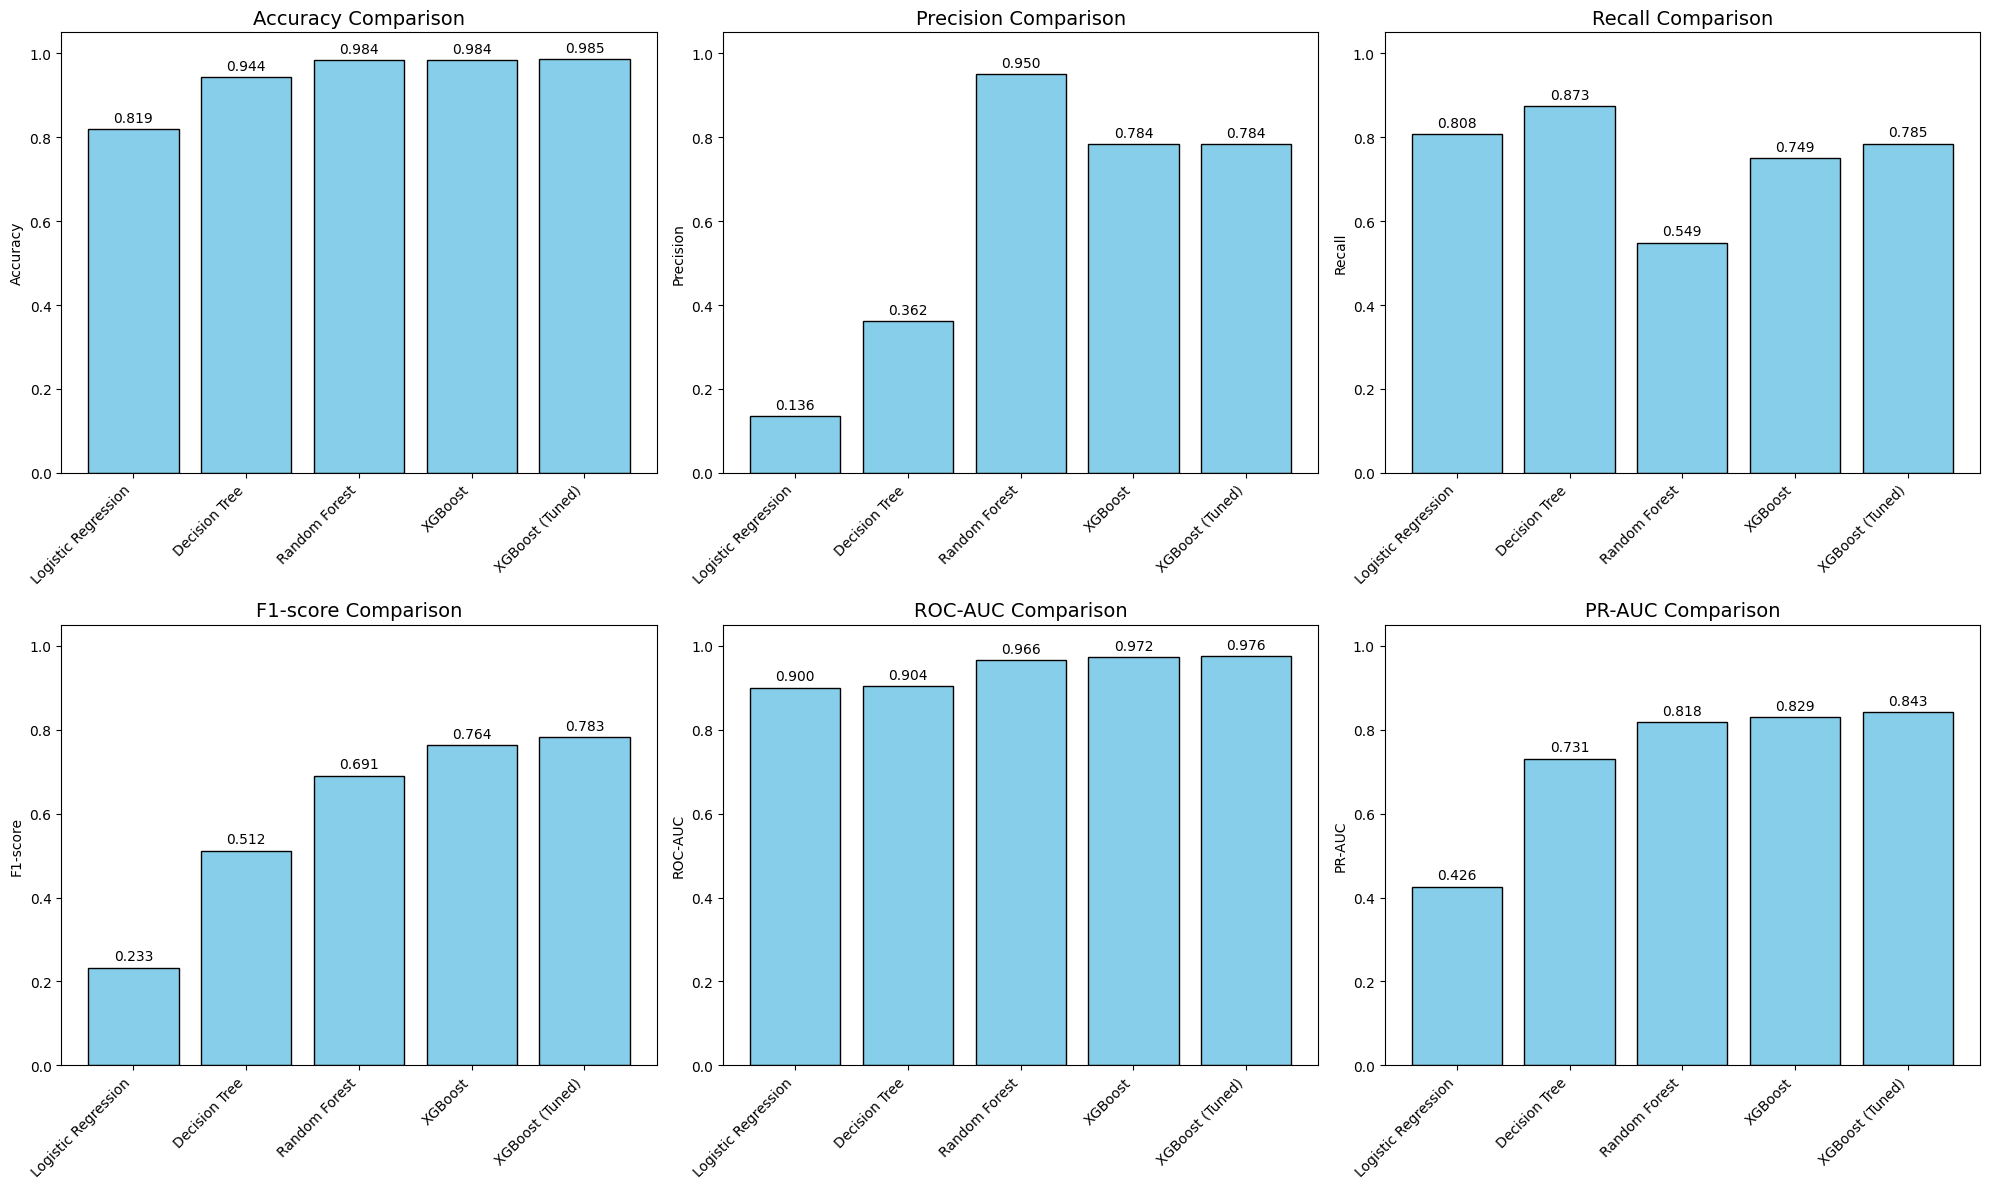

In [44]:
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC", "PR-AUC"]

# Bigger figure: more height and width
plt.figure(figsize=(20, 12))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    bars = plt.bar(df_results["Model"], df_results[metric], color="skyblue", edgecolor="black")
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 1.05)
    plt.ylabel(metric)
    plt.title(f"{metric} Comparison", fontsize=14)

    # Add values above bars
    for bar, val in zip(bars, df_results[metric]):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.3f}",
                 ha='center', va='bottom', fontsize=10)

# Adjust layout so labels and titles don't get cut off
plt.tight_layout()
plt.show()
